In [6]:
%load_ext autoreload
%autoreload 2

from fastai.vision import *
from PIL import Image
from matplotlib.pyplot import imshow
from pathlib import Path
from tqdm import tqdm
import utils as utils
from skimage import io
import utils as utils
from fastai.vision.models.xresnet import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
path = 'data/S2-allbands/crop/'

In [3]:
def label_for_rice(name):
    crops = (name.stem.split('-')[-1])
    
    return crops in ['B101', 'B102', 'B103']
class NPList(ImageList):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def open(self, fn):
        raw = np.load(str(fn))
        x = np.swapaxes(raw, 0, 2).astype(np.float32)
        return x

In [4]:
stats_eurosat_allbands = ([1353.73046875,
  1117.2020263671875,
  1041.8876953125,
  946.5513305664062,
  1199.1883544921875,
  2003.0101318359375,
  2374.01171875,
  2301.222412109375,
  732.1828002929688,
  12.099513053894043,
  1820.6893310546875,
  1118.1998291015625,
  2599.784912109375],
 [30.343395233154297,
  66.4549560546875,
  71.52734375,
  86.9700698852539,
  70.47565460205078,
  81.35286712646484,
  97.88168334960938,
  99.96805572509766,
  27.891748428344727,
  0.32882159948349,
  92.60734558105469,
  87.39993286132812,
  106.57888793945312])

In [5]:
data = NPList.from_folder(path, extensions=['.npy'])
data = data.split_by_rand_pct()
data = data.label_from_func(label_for_rice)
data = data.databunch()
data = data.normalize(stats_eurosat_allbands)

In [93]:
def create_model(data,  eurosat_url='data/xres7_fastai_allbandsiw5'):
    print('Importing custom xresnet50 pretrained on eurosat')

    model = xresnet50(c_in=13, c_out=10)
    st = torch.load(eurosat_url)
    model.load_state_dict(st)
    
    m_new = nn.Sequential(*list(model.children())[:-3], AdaptiveConcatPool2d(), Flatten(), nn.Linear(4096, 2))
    learn = Learner(data, m_new, metrics=[accuracy, utils.f1_score])
    first_layer = learn.layer_groups[0][:-4]
    second_layer = learn.layer_groups[0][-4:]
    learn.layer_groups = [first_layer, second_layer]


    
    return learn

In [97]:
learn = create_model(data)
learn.loss_func = LabelSmoothingCrossEntropy()

Importing custom xresnet50 pretrained on eurosat


In [98]:
learn.freeze_to(-1)
learn.fit_one_cycle(5, slice(1e-3))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.622891,0.552016,0.739437,0.260817,00:01
1,0.563189,0.513434,0.802817,0.547770,00:01
2,0.541449,0.504103,0.809859,0.631212,00:01
3,0.528344,0.506723,0.809859,0.572880,00:01
4,0.515576,0.509508,0.802817,0.585434,00:01


In [99]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-4))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.501513,0.504763,0.806338,0.604518,00:01
1,0.505111,0.502951,0.806338,0.627145,00:01
2,0.501268,0.506319,0.809859,0.621882,00:01
3,0.496967,0.502414,0.806338,0.624840,00:01
4,0.495525,0.503254,0.816901,0.636108,00:01


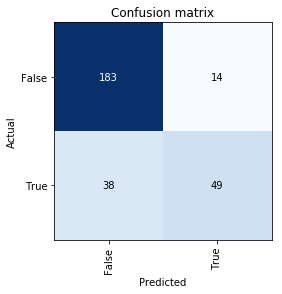

In [100]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_confusion_matrix()

## Basic model

In [8]:
model = xresnet50(c_in=13, c_out=10)

In [46]:
learn = create_model(data)

Importing custom xresnet50 pretrained on eurosat


In [48]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [32, 32, 32]         3,744      True      
______________________________________________________________________
BatchNorm2d          [32, 32, 32]         64         True      
______________________________________________________________________
ReLU                 [2048, 2, 2]         0          False     
______________________________________________________________________
Conv2d               [32, 32, 32]         9,216      True      
______________________________________________________________________
BatchNorm2d          [32, 32, 32]         64         True      
______________________________________________________________________
ReLU                 [2048, 2, 2]         0          False     
______________________________________________________________________
Conv2d               [64, 32, 32]         18,432     True      
___________________________________________________

In [49]:
learn.freeze_to(-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


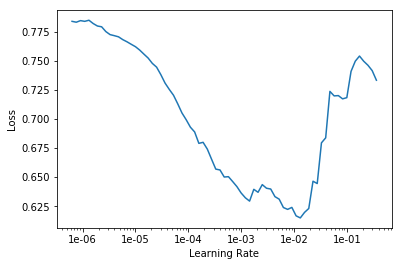

In [51]:
learn.lr_find()
learn.recorder.plot()

In [52]:
learn.fit_one_cycle(5, slice(1e-3))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.585173,0.478140,0.788732,0.644464,00:01
1,0.522369,0.442666,0.830986,0.695490,00:01
2,0.489747,0.446351,0.813380,0.677090,00:01
3,0.470828,0.433096,0.816901,0.681036,00:01
4,0.452516,0.435673,0.838028,0.687638,00:01


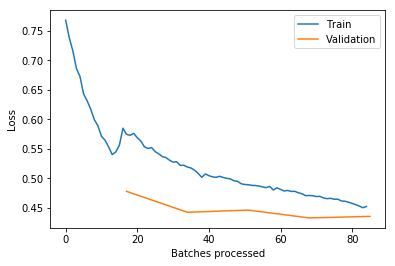

In [53]:
learn.recorder.plot_losses()

In [54]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


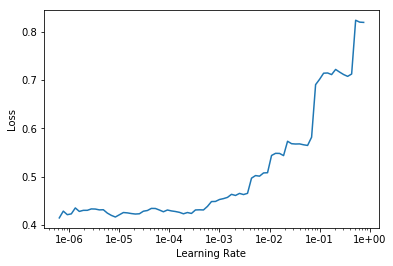

In [55]:
learn.lr_find()
learn.recorder.plot()

In [56]:
learn.fit_one_cycle(5, slice(1e-4))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.430535,0.438561,0.813380,0.593490,00:01
1,0.428480,0.440551,0.809859,0.563578,00:01
2,0.428107,0.433653,0.827465,0.647893,00:01
3,0.421835,0.425305,0.834507,0.673126,00:01
4,0.420152,0.428399,0.820423,0.616025,00:01


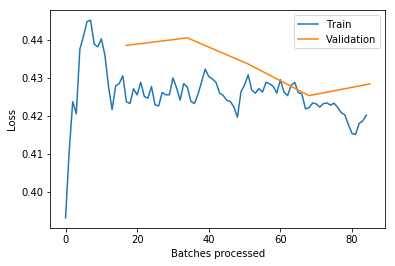

In [57]:
learn.recorder.plot_losses()

## LabelSmoothing model

In [58]:
learn = create_model(data)

Importing custom xresnet50 pretrained on eurosat


In [59]:
learn.loss_func = LabelSmoothingCrossEntropy()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


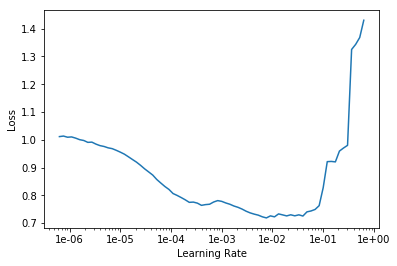

In [60]:
learn.lr_find()
learn.recorder.plot()

In [61]:
learn.fit_one_cycle(5, slice(1e-3))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.704659,0.563088,0.806338,0.669856,00:01
1,0.638426,0.615906,0.799296,0.535581,00:01
2,0.592911,0.524990,0.809859,0.625976,00:01
3,0.558033,0.517119,0.816901,0.592473,00:01
4,0.533056,0.516697,0.806338,0.556471,00:01


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


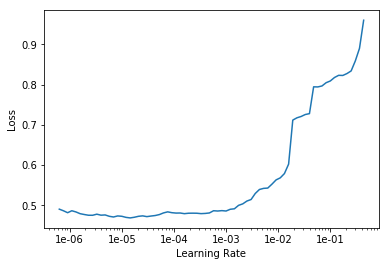

In [62]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [63]:
learn.fit_one_cycle(5, slice(1e-4))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.483260,0.500158,0.820423,0.660733,00:01
1,0.484711,0.500843,0.809859,0.649509,00:01
2,0.478263,0.508823,0.820423,0.616660,00:01
3,0.475250,0.499148,0.830986,0.662450,00:01
4,0.476445,0.499850,0.830986,0.662450,00:01


In [64]:
learn.loss_func

LabelSmoothingCrossEntropy()

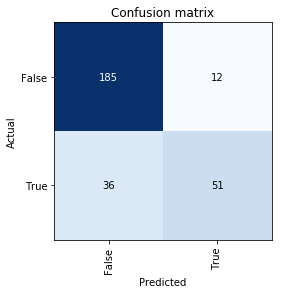

In [65]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_confusion_matrix()

## Mixup augmentation model

In [101]:
learn = create_model(data)
learn.loss_func = LabelSmoothingCrossEntropy()
learn = learn.mixup()

Importing custom xresnet50 pretrained on eurosat


In [102]:
learn.freeze_to(-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


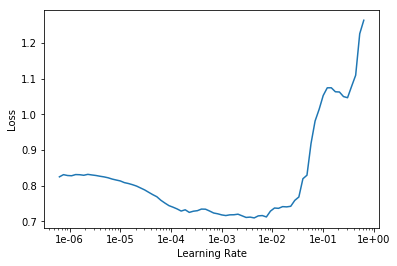

In [72]:
learn.lr_find()
learn.recorder.plot()

In [103]:
learn.fit_one_cycle(10, slice(1e-3))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.624601,0.589911,0.693662,0.000000,00:01
1,0.595447,0.503828,0.809859,0.633896,00:01
2,0.573063,0.558085,0.704225,0.081536,00:01
3,0.559227,0.499890,0.820423,0.661866,00:01
4,0.564912,0.560627,0.771127,0.643910,00:01
5,0.565161,0.564130,0.771127,0.622453,00:01
6,0.561634,0.509318,0.809859,0.590743,00:01
7,0.552409,0.513300,0.809859,0.550326,00:01
8,0.543460,0.504870,0.809859,0.631242,00:01
9,0.539049,0.507796,0.813380,0.635937,00:01


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


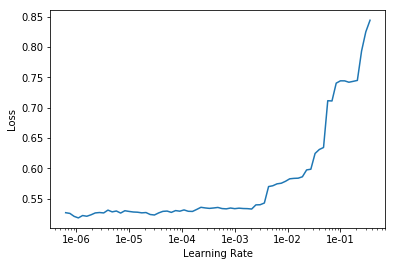

In [104]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [105]:
learn.fit_one_cycle(15, slice(1e-4))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.531577,0.503985,0.823944,0.645102,00:01
1,0.522351,0.505630,0.813380,0.587384,00:01
2,0.525097,0.509486,0.820423,0.643468,00:01
3,0.526710,0.504789,0.823944,0.641164,00:01
4,0.527244,0.505771,0.813380,0.627951,00:01
5,0.525904,0.500669,0.820423,0.634925,00:01
6,0.523787,0.502247,0.827465,0.619253,00:01
7,0.525585,0.499921,0.820423,0.643061,00:01
8,0.525206,0.495104,0.816901,0.646550,00:01
9,0.526894,0.498934,0.813380,0.628772,00:01


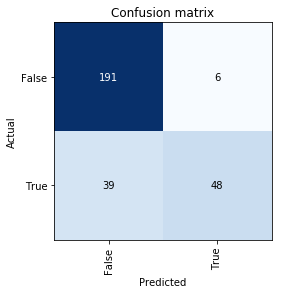

In [106]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_confusion_matrix()